In [7]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from itertools import product

# 3. ระบุเส้นทางโฟลเดอร์ภาพ
depth_left_folder = r"D:\EE Engineer\Year4\project\Image\Camera3\Left3"  # โฟลเดอร์ภาพจากกล้องซ้ายสำหรับcalibrate
depth_right_folder = r"D:\EE Engineer\Year4\project\Image\Camera3\Right3"  # โฟลเดอร์ภาพจากกล้องขวาสำหรับcalibrate

# 4. โหลดภาพจากโฟลเดอร์
depth_images_left = glob.glob(os.path.join(depth_left_folder, '*.jpg'))  # โหลดไฟล์ภาพ .png จากกล้องซ้าย
depth_images_right = glob.glob(os.path.join(depth_right_folder, '*.jpg'))  # โหลดไฟล์ภาพ .png จากกล้องขวา

# 5. ตรวจสอบจำนวนภาพ
print(f"จำนวนภาพจากกล้องซ้าย: {len(depth_images_left)}")
print(f"จำนวนภาพจากกล้องขวา: {len(depth_images_right)}")

if len(depth_images_left) != len(depth_images_right):
    print("จำนวนภาพในโฟลเดอร์ซ้ายและขวาไม่เท่ากัน")
print("Left" ,depth_images_left)
print("Right" ,depth_images_right)

จำนวนภาพจากกล้องซ้าย: 346
จำนวนภาพจากกล้องขวา: 346
Left ['D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0000.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0001.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0002.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0003.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0004.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0005.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0006.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0007.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0008.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0009.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0010.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0011.jpg', 'D:\\EE Engineer\\Year4\\project\\Image\\Camera3\\Left3\\left_0012.

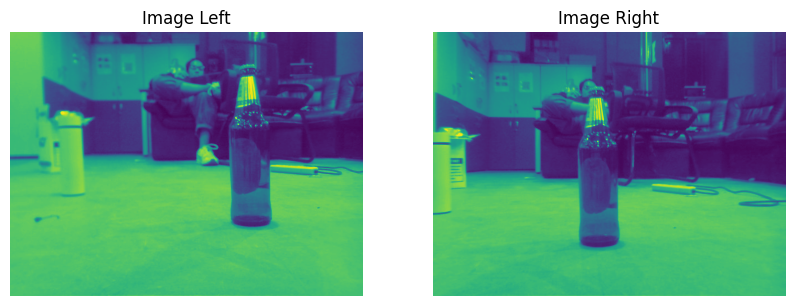

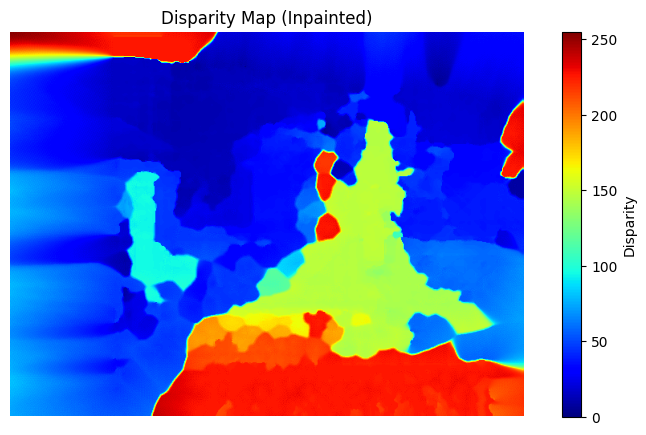

In [39]:

fs = cv2.FileStorage('stereo_params.yml', cv2.FILE_STORAGE_READ)
M1 = fs.getNode('M1').mat()
D1 = fs.getNode('D1').mat()
M2 = fs.getNode('M2').mat()
D2 = fs.getNode('D2').mat()
R1 = fs.getNode('R1').mat()
R2 = fs.getNode('R2').mat()
P1 = fs.getNode('P1').mat()
P2 = fs.getNode('P2').mat()
Q = fs.getNode('Q').mat()
fs.release()

# โหลดภาพซ้ายและขวา
imgL = cv2.imread(depth_images_left[73], cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(depth_images_right[73], cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL)
plt.title('Image Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imgR)
plt.title('Image Right')
plt.axis('off')

plt.show()
# Rectify ภาพ
mapLx, mapLy = cv2.initUndistortRectifyMap(M1, D1, R1, P1, imgL.shape[::-1], cv2.CV_32FC1)
mapRx, mapRy = cv2.initUndistortRectifyMap(M2, D2, R2, P2, imgR.shape[::-1], cv2.CV_32FC1)
rectifiedL = cv2.remap(imgL, mapLx, mapLy, cv2.INTER_LINEAR)
rectifiedR = cv2.remap(imgR, mapRx, mapRy, cv2.INTER_LINEAR)

# สร้าง StereoSGBM สำหรับการคำนวณ Disparity
minDisparity = 0  # ความแตกต่างต่ำสุด
numDisparities = 16 * 8  # ความแตกต่างทั้งหมด ต้องเป็นเลขที่หารด้วย 16 ลงตัว
blockSize = 7  # ขนาดของบล็อก (ค่าที่เล็กเกินไปอาจทำให้ผลลัพธ์มี noise)

# ค่าพารามิเตอร์เพิ่มเติม
P1 = 8 * 3 * blockSize**2  # ค่าปรับความเรียบ (ต่ำ) โดยขึ้นอยู่กับขนาด blockSize
P2 = 32 * 3 * blockSize**2  # ค่าปรับความเรียบ (สูง)
disp12MaxDiff = 1  # ความแตกต่างระหว่าง Disparity Map ซ้าย/ขวา
preFilterCap = 63  # ตัวกรองสำหรับปรับค่าพิกเซลให้เหมาะสมก่อนเปรียบเทียบ
uniquenessRatio = 10  # อัตราส่วนที่กำหนดว่าค่าที่ดีที่สุดต้องดีกว่าค่าอื่นๆ
speckleWindowSize = 50  # ขนาดหน้าต่างสำหรับตรวจจับ noise (จุดเล็ก)
speckleRange = 1  # ความแตกต่างของ disparity ภายใน noise
mode = cv2.STEREO_SGBM_MODE_SGBM  # เลือกโหมด SGBM

# สร้างตัวคำนวณ
stereo = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    preFilterCap=preFilterCap,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    mode=mode,
)

# คำนวณ Disparity Map
disparity = stereo.compute(rectifiedL, rectifiedR).astype(np.float32) / 16.0


# สร้าง Mask สำหรับจุดที่ disparity <= 0
mask = (disparity <= 0).astype(np.uint8)

# ใช้ cv2.inpaint เพื่อเติมค่าจากบริเวณใกล้เคียง
disparity_inpainted = cv2.inpaint(disparity.astype(np.float32), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# ปรับขนาด Disparity Map ที่ผ่านการเติมค่าให้เหมาะสมสำหรับการแสดงผล
disparity_normalized = cv2.normalize(disparity_inpainted, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# แปลง Disparity Map ที่ปรับปรุงแล้วไปเป็น Depth Map
depth_map = cv2.reprojectImageTo3D(disparity_inpainted, Q)

# แสดงผล Disparity Map ที่เติมค่าแล้ว
plt.figure(figsize=(10, 5))
plt.imshow(disparity_normalized, cmap='jet')
plt.colorbar(label='Disparity')
plt.title('Disparity Map (Inpainted)')
plt.axis('off')
plt.show()

# บันทึก Disparity Map และ Depth Map ที่ปรับปรุงแล้ว
cv2.imwrite('disparity_map_inpainted.jpg', disparity_normalized)
np.save('depth_map_inpainted.npy', depth_map)


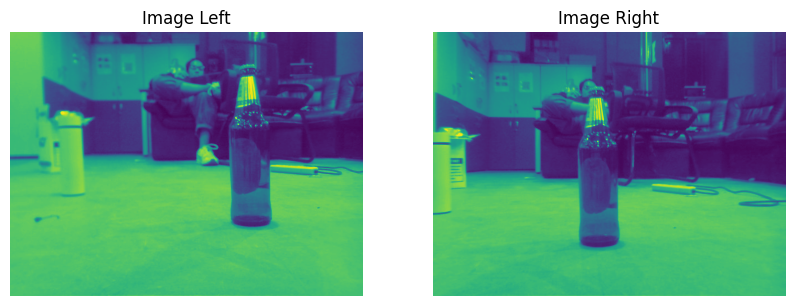

C:\Users\user\AppData\Local\Temp\ipykernel_14488\163324599.py:26: RuntimeWarning: divide by zero encountered in divide
  depth_map_cm = (baseline_cm * focal_length_px) / disparity_filtered  # สมการ Depth Map


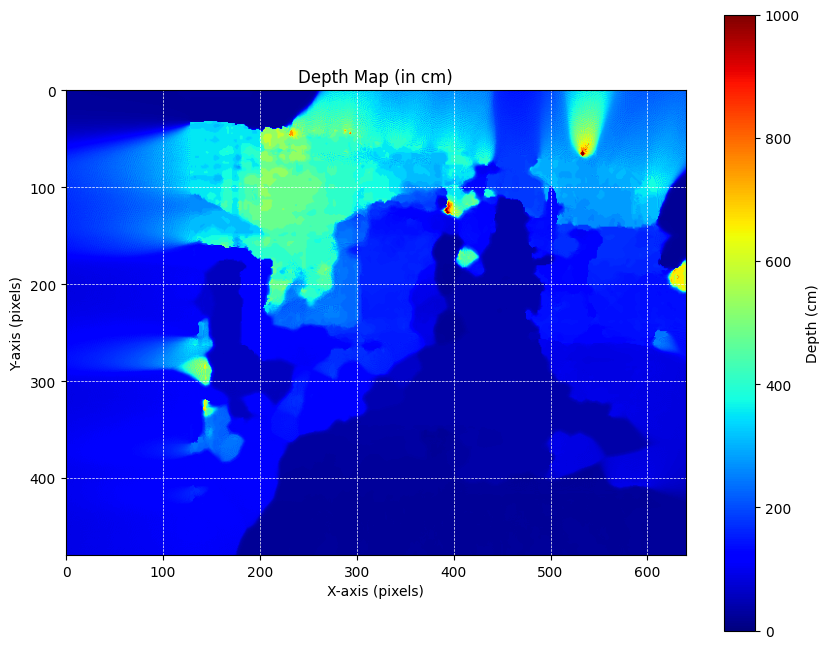

Min Depth: 22.735629310344823 cm
Max Depth: 1000.0 cm


In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL)
plt.title('Image Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imgR)
plt.title('Image Right')
plt.axis('off')

plt.show()
# 1. ปรับปรุงคุณภาพของ Disparity Map
# ใช้ Median Filter เพื่อลด Noise
disparity_filtered = cv2.medianBlur(disparity_normalized, 5)  # Kernel ขนาด 5x5

# 2. หลีกเลี่ยงปัญหาการหารด้วยศูนย์ใน Depth Map
disparity_filtered = disparity_filtered.astype(np.float32)  # แปลงเป็น float สำหรับการคำนวณ
disparity_filtered[disparity_filtered <= 0] = 0.1  # ป้องกันค่าเป็นศูนย์
disparity_filtered = cv2.inpaint(disparity_normalized.astype(np.uint8), mask, 5, cv2.INPAINT_TELEA)

# 3. คำนวณ Depth Map (ในหน่วยเซนติเมตร)
baseline_cm = 9.7  # ระยะห่างระหว่างกล้อง (เซนติเมตร)
focal_length_px = 543.78  # ระยะโฟกัส (พิกเซล)

depth_map_cm = (baseline_cm * focal_length_px) / disparity_filtered  # สมการ Depth Map
depth_map_cm[depth_map_cm > 1000] = 1000  # จำกัดระยะลึกไม่เกิน 1000 เซนติเมตร

# 4. Normalize โดยตรงตามช่วงค่าที่ต้องการแสดงผล (0 ถึง 1000 cm)
depth_map_normalized = ((depth_map_cm / 1000) * 255).astype(np.uint8)  # 1000 cm = 255

# 5. เพิ่ม Contrast ด้วย Histogram Equalization
depth_map_eq = cv2.equalizeHist(depth_map_normalized)

# 6. แสดงผล Depth Map
# Normalize Depth Map
norm = plt.Normalize(vmin=0, vmax=1000)

# สร้าง Depth Map พร้อมปรับสเกล Colorbar เป็น 0-1000
plt.figure(figsize=(10, 8))
plt.imshow(depth_map_cm, cmap='jet', norm=norm)
cbar = plt.colorbar()
cbar.set_label('Depth (cm)')    
cbar.set_ticks(np.linspace(0, 1000, 6))  # แสดง tick เป็น 0, 200, 400, 600, 800, 1000
cbar.ax.set_yticklabels([f"{int(tick)}" for tick in np.linspace(0, 1000, 6)])

# เพิ่ม Title และ Label
plt.title('Depth Map (in cm)')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()


print(f"Min Depth: {depth_map_cm.min()} cm")
print(f"Max Depth: {depth_map_cm.max()} cm")


# 7. บันทึก Depth Map
cv2.imwrite('depth_map_eq.jpg', depth_map_eq)
np.save('depth_map_cm.npy', depth_map_cm)


In [ ]:
import numpy as np

# Intrinsic Parameters
focal_length_px = 543.78  # Focal Length (ในพิกเซล)
cx, cy = 335.38, 236.73   # Optical Center (cx, cy)

# พิกัดในภาพที่ต้องการ (x, y)
x, y = 150, 250  # ตัวอย่างพิกัด (ในพิกเซล)

# ค่า Depth Map ที่พิกัด (x, y)
Z = depth_map_cm[y, x]  # ค่า Depth ในเซนติเมตรที่ตำแหน่ง (x, y)

# คำนวณพิกัดในโลกจริง (3D Coordinates)
X = (x - cx) * Z / focal_length_px
Y = (y - cy) * Z / focal_length_px

print(f"3D Coordinates at pixel ({x}, {y}):")
print(f"X: {X:.2f} cm, Y: {Y:.2f} cm, Z: {Z:.2f} cm")


3D Coordinates at pixel (150, 250):
X: -23.35 cm, Y: 1.67 cm, Z: 68.50 cm


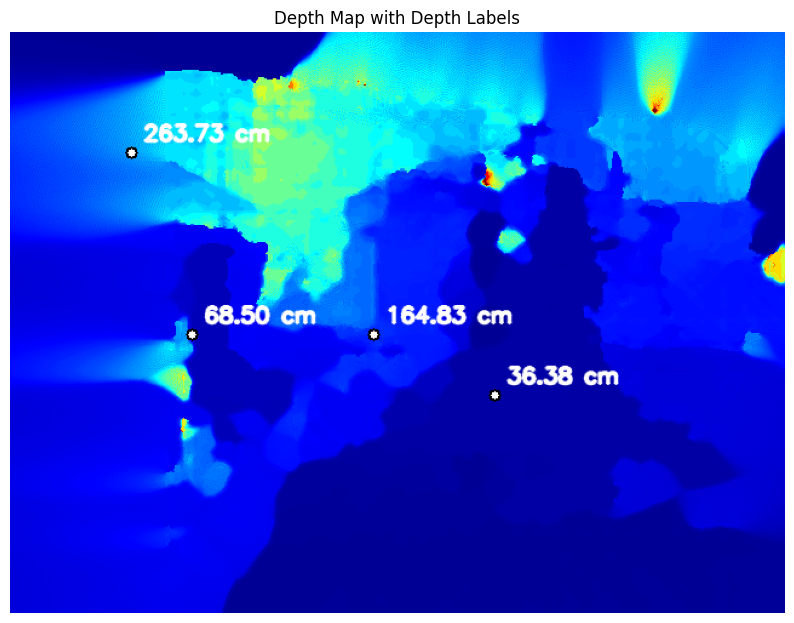

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ตัวอย่าง Depth Map (ใช้ Depth Map ที่คุณคำนวณได้)
# depth_map_cm: เป็น Depth Map ในหน่วยเซนติเมตร
# depth_map_normalized: Depth Map แบบ Normalize เพื่อแสดงผล

# กำหนดจุดที่จะวัด (4 จุด)
points = [(100, 100), (150, 250), (300, 250), (400, 300)]  # พิกัด (x, y)

# สร้างสำเนาของ Depth Map สำหรับแสดงผล
depth_map_labeled = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)  # ใช้ Colormap เพื่อแสดงผลสี

# ใส่ Label สำหรับแต่ละจุด
for point in points:
    x, y = point
    Z = depth_map_cm[y, x]  # ค่า Depth (เซนติเมตร) ที่ตำแหน่ง (x, y)
    label = f"{Z:.2f} cm"  # ข้อความที่จะแสดง

    # วาดจุดวงกลมที่ตำแหน่ง (x, y)
    cv2.circle(depth_map_labeled, (x, y), 5, (0, 0, 0), -1)  # จุดสีดำ
    cv2.circle(depth_map_labeled, (x, y), 3, (255, 255, 255), -1)  # จุดสีขาวเล็กในจุดเดียวกัน

    # วาดข้อความค่าความลึก (Label)
    cv2.putText(depth_map_labeled, label, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2, cv2.LINE_AA)  # สีขาว (ข้อความ)

# แสดงภาพ Depth Map พร้อม Label
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(depth_map_labeled, cv2.COLOR_BGR2RGB))  # แปลง BGR เป็น RGB เพื่อให้สีถูกต้อง
plt.title('Depth Map with Depth Labels')
plt.axis('off')
plt.show()


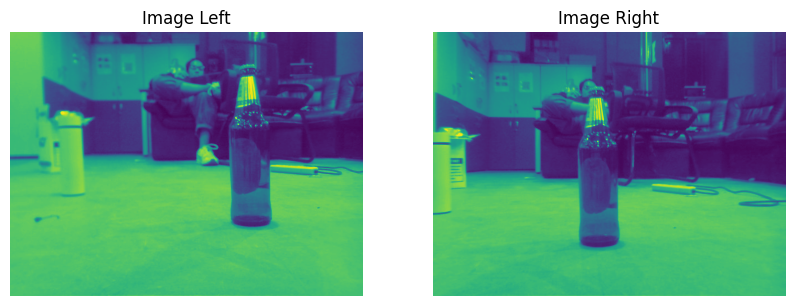

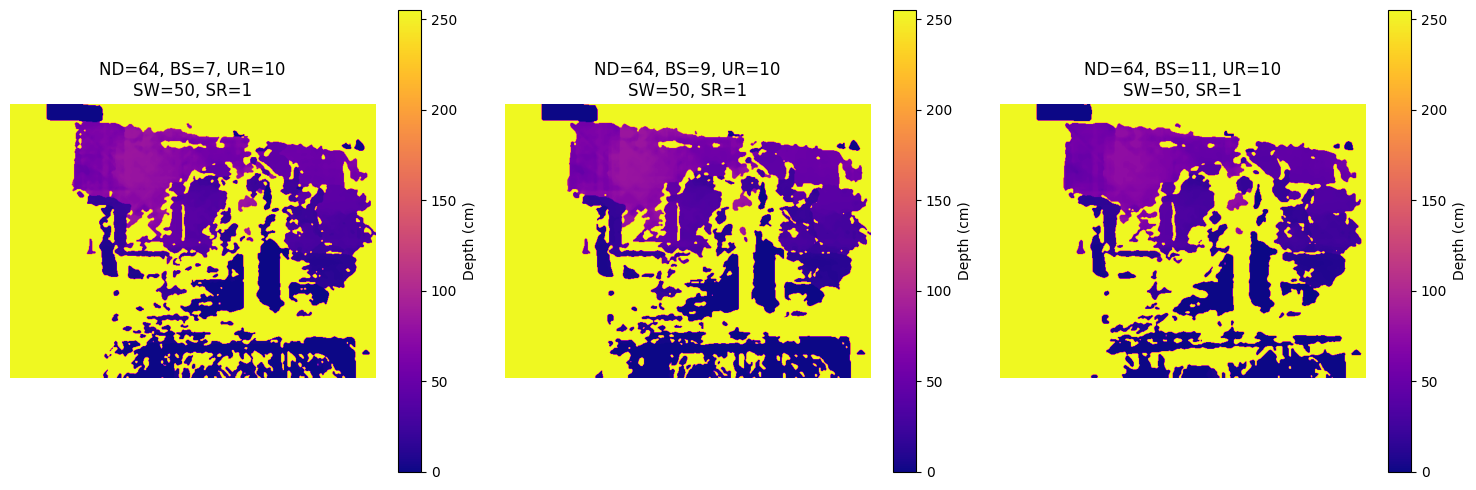

In [29]:

fs = cv2.FileStorage('stereo_params.yml', cv2.FILE_STORAGE_READ)
M1 = fs.getNode('M1').mat()
D1 = fs.getNode('D1').mat()
M2 = fs.getNode('M2').mat()
D2 = fs.getNode('D2').mat()
R1 = fs.getNode('R1').mat()
R2 = fs.getNode('R2').mat()
P1 = fs.getNode('P1').mat()
P2 = fs.getNode('P2').mat()
Q = fs.getNode('Q').mat()
fs.release()

# โหลดภาพซ้ายและขวา
imgL = cv2.imread(depth_images_left[73], cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(depth_images_right[73], cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL)
plt.title('Image Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imgR)
plt.title('Image Right')
plt.axis('off')

plt.show()
# Rectify ภาพ (ใช้พารามิเตอร์จาก stereo_params.yml)
mapLx, mapLy = cv2.initUndistortRectifyMap(M1, D1, R1, P1, imgL.shape[::-1], cv2.CV_32FC1)
mapRx, mapRy = cv2.initUndistortRectifyMap(M2, D2, R2, P2, imgR.shape[::-1], cv2.CV_32FC1)
rectifiedL = cv2.remap(imgL, mapLx, mapLy, cv2.INTER_LINEAR)
rectifiedR = cv2.remap(imgR, mapRx, mapRy, cv2.INTER_LINEAR)

# สร้าง StereoSGBM สำหรับการคำนวณ Disparity
numDisparities_list = [64]
blockSize_list = [7,9,11]
uniquenessRatio_list = [10]
speckleWindowSize_list = [50]
speckleRange_list = [1]
# สร้าง Cartesian Product ของพารามิเตอร์ทั้งหมด
param_combinations = list(product(numDisparities_list, blockSize_list, uniquenessRatio_list, speckleWindowSize_list, speckleRange_list))


baseline_cm = 9.7  # ระยะห่างระหว่างกล้องในเซนติเมตร
focal_length_px = 543.78  # ระยะโฟกัสในพิกเซล (จาก M1)

results = []  # เก็บผลลัพธ์ของแต่ละชุดพารามิเตอร์
for params in param_combinations:
    numDisparities, blockSize, uniquenessRatio, speckleWindowSize, speckleRange = params
    
    # คำนวณค่า P1 และ P2 ตามสูตร
    P1 = 8 * 3 * blockSize**2
    P2 = 32 * 3 * blockSize**2

    # สร้างตัวคำนวณ StereoSGBM
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=numDisparities,
        blockSize=blockSize,
        P1=P1,
        P2=P2,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=1,
        mode=cv2.STEREO_SGBM_MODE_SGBM
    )

    # คำนวณ Disparity Map
    disparity = stereo.compute(rectifiedL, rectifiedR).astype(np.float32) / 16.0

    # **1. ลด Noise ใน Disparity Map**
    disparity_filtered = cv2.medianBlur(disparity, 5)  # ใช้ Median Filter

    # **2. ป้องกันปัญหาการหารด้วยศูนย์**
    disparity_filtered[disparity_filtered <= 0] = 0.1  # แทนที่ค่า <= 0 ด้วย 0.1

    # **3. คำนวณ Depth Map**
    depth_map_cm = (baseline_cm * focal_length_px) / disparity_filtered
    depth_map_cm[depth_map_cm > 1000] = 1000  # จำกัดค่า Outliers

    # **4. ปรับปรุง Contrast ของ Depth Map**
    depth_map_normalized = cv2.normalize(depth_map_cm, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    depth_map_eq = cv2.equalizeHist(depth_map_normalized)

    # เก็บผลลัพธ์
    results.append({
        'params': params,
        'depth_map': depth_map_eq
    })

# การแสดงผล Depth Map ของแต่ละชุดพารามิเตอร์ พร้อมสเกลระยะทาง
n_results = len(results)
rows = int(np.ceil(n_results / 3))  # จำนวนแถว (แสดง 3 รูปต่อแถว)
cols = 3  # จำนวนคอลัมน์
plt.figure(figsize=(15, rows * 5))

for i, result in enumerate(results):
    plt.subplot(rows, cols, i + 1)
    params = result['params']
    depth_map = result['depth_map']

    # แสดงภาพ Depth Map พร้อมสเกลระยะทาง
    im = plt.imshow(depth_map, cmap='plasma', extent=[0, depth_map.shape[1], depth_map.shape[0], 0], vmax=255)
    plt.colorbar(im, label='Depth (cm)')
    plt.title(f"ND={params[0]}, BS={params[1]}, UR={params[2]}\nSW={params[3]}, SR={params[4]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# กำหนดค่าพารามิเตอร์
baseline_cm = 9.3  # ระยะห่างระหว่างกล้องในหน่วยเซนติเมตร
focal_length_px = 543.78  # ค่าระยะโฟกัสในหน่วยพิกเซล (จาก M1)

disparity[disparity <= 0] = 0.1

# **1. ลด Noise ใน Disparity Map**
# ใช้ Median Filter เพื่อลด Noise และรักษาขอบ
disparity_filtered = cv2.medianBlur(disparity, 5)  # Kernel ขนาด 5x5

# **2. ป้องกันปัญหาการหารด้วยศูนย์**
# แทนที่ค่า disparity ที่มีค่าน้อยกว่าหรือเท่ากับ 0 ด้วยค่าขั้นต่ำ (0.1)
disparity_filtered[disparity_filtered <= 0] = 0.1

# **3. คำนวณ Depth Map**
# ใช้สมการ Depth = (Baseline * Focal Length) / Disparity
depth_map_cm = (baseline_cm * focal_length_px) / disparity_filtered

# ตัดค่า Outliers: ระยะทางที่มากกว่า 1000 cm จะถูกจำกัดไว้ที่ 1000 cm
depth_map_cm[depth_map_cm > 1000] = 1000

# **4. ปรับปรุง Contrast ของ Depth Map**
# Normalization และปรับ Histogram ให้สมดุล
depth_map_normalized = cv2.normalize(depth_map_cm, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
depth_map_eq = cv2.equalizeHist(depth_map_normalized)

# **5. การแสดงผล**
plt.figure(figsize=(12, 10))
'''
# Disparity Map (Filtered)
plt.subplot(1, 3, 1)
plt.imshow(disparity_filtered, cmap='viridis')
plt.colorbar(label='Disparity (pixels)')
plt.title('Filtered Disparity Map')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')

# Depth Map (Raw)
plt.subplot(1, 3, 2)
plt.imshow(depth_map_cm, cmap='jet')
plt.colorbar(label='Depth (cm)')
plt.title('Raw Depth Map (in cm)')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')'''

# Depth Map (Enhanced)
#plt.subplot(1, 3, 3)
plt.imshow(depth_map_eq, cmap='jet')
plt.colorbar(label='Normalized Depth')
plt.title('Enhanced Depth Map')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')

# แสดงภาพทั้งหมด
plt.tight_layout()
plt.show()
